In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [2]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = findROIContour(thresh, (x-10, y-10, 20, 20))
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

# Calculate avg area of box
def avgArea(box, total, count):
    x, y, w, h = box
    total += w * h
    avg = total / count
    return total, avg




### Remove Duplicates

In [3]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10.pkl')
#waggle_df.drop(['index'], axis=1, inplace=True)
#waggle_df.reset_index(inplace=True)
# Sort by cluster and then frame so the dataset is ordered in blocks of clusters
waggle_df = waggle_df.sort_values(by=['Cluster', 'frame']).reset_index().drop(['index', 'level_0'], axis=1).reset_index()

In [4]:
waggle_df[waggle_df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
65,65,1230,317,111,331.5,"[[[1223, 289]], [[1224, 290]], [[1225, 291]], ...",2
66,66,1230,327,123,287.0,"[[[1263, 305]], [[1263, 306]], [[1263, 307]], ...",2
67,67,1248,311,125,351.5,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
70,70,1239,302,127,535.5,"[[[1237, 281]], [[1236, 282]], [[1236, 283]], ...",2
71,71,1261,328,128,259.0,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2
74,74,1242,300,130,408.0,"[[[1235, 282]], [[1234, 283]], [[1233, 283]], ...",2


In [5]:
# All rows duplicated on frame and cluster
dup = waggle_df[waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster
dup

# All non duplicated rows
non_dup = waggle_df[~waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [6]:
dup

,index,x,y,frame,size,contour,Cluster
1,1,1076,261,3,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,2,1041,250,3,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
5,5,1037,247,10,358.5,"[[[1052, 226]], [[1051, 227]], [[1050, 227]], ...",0
6,6,1075,243,10,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
7,7,1075,254,11,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
...,...,...,...,...,...,...,...
6740,6740,1237,465,13566,697.5,"[[[1254, 424]], [[1254, 425]], [[1254, 426]], ...",275
6751,6751,1228,495,13599,443.5,"[[[1221, 468]], [[1221, 469]], [[1221, 470]], ...",276
6752,6752,1205,483,13599,274.0,"[[[1214, 467]], [[1213, 468]], [[1212, 468]], ...",276
6759,6759,1227,513,13612,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",276


In [7]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = waggle_df[waggle_df.index.isin(idx)]
df['Cluster'].value_counts()

123    53
86     52
70     50
275    42
26     42
       ..
64      1
259     1
47      1
53      1
132     1
Name: Cluster, Length: 202, dtype: int64

In [8]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
70,70,1239,302,127,535.5,"[[[1237, 281]], [[1236, 282]], [[1236, 283]], ...",2
71,71,1261,328,128,259.0,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2


In [9]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
# Returns pts with furthest duplicates removed
final_pts = np.delete(pts, remove_row, axis = 0)

In [10]:
# Concatenate final_pts index with non_duplicate index, removing unique values
final_idx = np.unique(np.concatenate((non_dup.index.values, final_pts[:, 0])))

In [11]:
df = waggle_df[waggle_df['index'].isin(final_idx)]

In [12]:
df['Cluster'].value_counts()
#df[df['Cluster']==229]

72     51
275    48
82     48
123    47
85     45
       ..
46     10
136    10
262     9
257     8
75      5
Name: Cluster, Length: 277, dtype: int64

In [13]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
65,65,1230,317,111,331.5,"[[[1223, 289]], [[1224, 290]], [[1225, 291]], ...",2
66,66,1230,327,123,287.0,"[[[1263, 305]], [[1263, 306]], [[1263, 307]], ...",2
67,67,1248,311,125,351.5,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
68,68,1239,295,126,292.0,"[[[1244, 282]], [[1243, 283]], [[1242, 283]], ...",2
69,69,1261,328,127,258.5,"[[[1262, 316]], [[1261, 317]], [[1261, 318]], ...",2
72,72,1242,305,128,452.5,"[[[1244, 285]], [[1244, 286]], [[1244, 287]], ...",2
73,73,1242,304,129,498.5,"[[[1235, 280]], [[1234, 281]], [[1234, 282]], ...",2
74,74,1242,300,130,408.0,"[[[1235, 282]], [[1234, 283]], [[1233, 283]], ...",2
75,75,1256,308,133,281.0,"[[[1228, 290]], [[1229, 290]], [[1230, 290]], ...",2
76,76,1250,295,140,318.0,"[[[1242, 270]], [[1241, 271]], [[1240, 272]], ...",2


### Fill Missing

In [14]:
# Prevent tracking update failures
def anchorBox(box, prev_box, avg):
    global counter
    x0, y0, w0, h0 = prev_box
    x, y, w, h = box
    
    # If bounding box is too far from previous box
    #if abs(x - x0) > w0/2 and abs(y - y0) > h0/2:
    if abs(x - x0) > w0/2 or abs(y - y0) > h0/2: # CHANGED FOR TESTING ON BEES10 2
        print('Box Lost')
        success = False
    # If bounding box is too large
    elif abs(w * h) > (avg * 2):
        print('Box Lost (Expanded)')
        print(str(counter))
        success = 'Expanded'
    # If bounding box is too small
    elif abs(w * h) < (avg / 2):
        print('Box Lost (Shrunk)')
        print(str(counter))
        success = 'Shrunk'
    # prev_box only updated if box found
    else:
        print('Box Found')
        prev_box = box 
        success = True

    return success, prev_box

def expandBox(img, bbox):
    contour = None
    x, y, w, h = bbox
    x -= 10
    w += 20
    y -= 10
    h += 20
    bbox = (x, y, w, h)
    print(bbox)
    contour = findROIContour(img, bbox)
    return bbox, contour

# Find which way object is facing by the direction in which bounding box moves, to be coupled with angle of bounding rect
def moveDirection(prev_bbox, bbox):
    x, y, w, h = bbox
    x0, y0, w0, h0 = prev_bbox
    
    xd = x - x0
    # if xd is negative, moved west, if xd is positive, moved east
    yd = y - y0
    # if yd is negative, moved north, if yd is positive, moved south
    movement = (xd, yd)
    return movement

In [15]:
clust = df[df['Cluster']==6]
clust

,index,x,y,frame,size,contour,Cluster
122,122,839,481,201,259.0,"[[[853, 458]], [[852, 459]], [[853, 458]], [[8...",6
123,123,828,485,223,344.5,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",6
124,124,834,488,224,508.0,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",6
125,125,825,482,225,336.5,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",6
126,126,825,484,226,484.0,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",6
127,127,823,483,227,342.5,"[[[818, 467]], [[818, 468]], [[817, 469]], [[8...",6
128,128,823,478,235,303.5,"[[[824, 466]], [[823, 467]], [[822, 468]], [[8...",6
129,129,823,479,237,244.5,"[[[822, 461]], [[821, 462]], [[820, 463]], [[8...",6
130,130,826,471,238,405.0,"[[[827, 458]], [[826, 459]], [[825, 460]], [[8...",6
131,131,819,474,239,413.0,"[[[823, 458]], [[822, 459]], [[821, 460]], [[8...",6


500
202
Missing
Box Found
202
203
Missing
Box Found
203
204
Missing
Box Found
204
205
Missing
Box Found
205
206
Missing
Box Found
206
207
Missing
Box Found
207
208
Missing
Box Found
208
209
Missing
Box Found
209
210
Missing
Box Found
210
211
Missing
Box Found
211
212
Missing
Box Found
212
213
Missing
Box Found
213
214
Missing
Box Found
214
215
Missing
Box Found
215
216
Missing
Box Found
216
217
Missing
Box Found
217
218
Missing
Box Found
218
219
Missing
Box Found
219
220
Missing
Box Found
220
221
Missing
Box Found
221
222
Missing
Box Found
222
223
In DF
   level_0  index    x    y  frame   size  \
0      123    123  828  485    223  344.5   

                                             contour  Cluster  
0  [[[819, 472]], [[819, 473]], [[819, 474]], [[8...        6  
223
224
In DF
   level_0  index    x    y  frame   size  \
0      124    124  834  488    224  508.0   

                                             contour  Cluster  
0  [[[819, 472]], [[819, 473]], [[819, 474]], [[8...

ZeroDivisionError: float division by zero

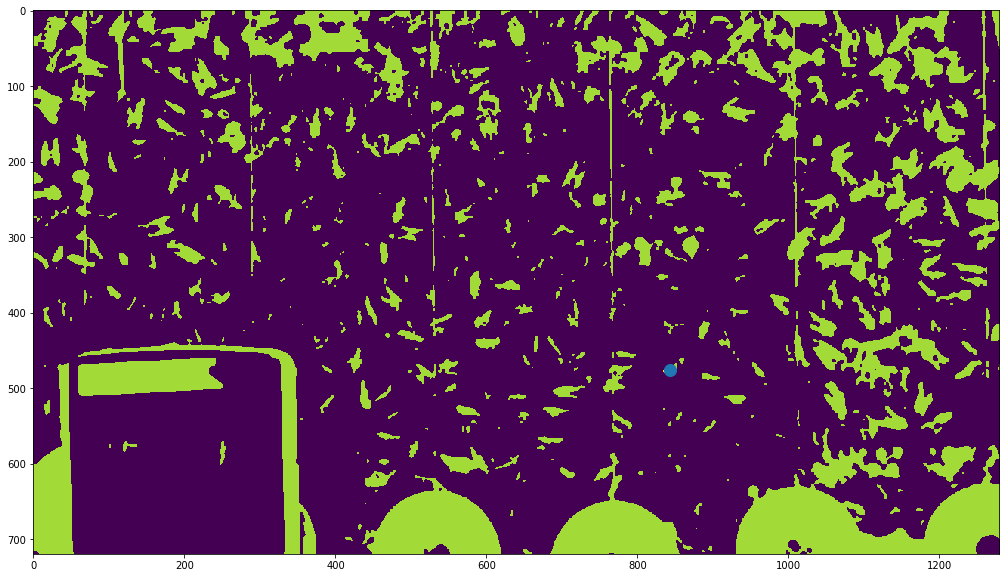

In [24]:
start = clust.iloc[0, :]['frame']
end = clust.iloc[-1, :]['frame']
# Get range of frames where waggle occurs
rang = np.arange(start, end, 1)
missing = list(set(rang)-set(clust.frame.values)) # Frames where waggle missing from df

counter = start
cap = cv2.VideoCapture('Bees10.mov')
cap.set(1, start)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.iloc[0, :]['x'], clust.iloc[0]['y']
box = x-10, y-10, 20, 20

contour = findROIContour(opening, box)
centre = getContourMoment(contour)
plt.figure(figsize=(20,10))
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.imshow(opening)
plt.plot(centre[0], centre[1], marker='o', markersize=12)
contour = findFullContour(opening, centre)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)
prev_bbox = bbox
avg = bbox[2]*bbox[3]
total = avg
print(avg)

# Create tracker 
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

rois = []

while counter < end:
    counter += 1 
    print(counter)
    ret, frame = cap.read()
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
    opening = cv2.erode(opening, kernel, iterations=1)

    # If frame not in df, use tracker to fill in the missing
    if counter in missing:
        print('Missing')
        # update tracker
        ret, bbox = tracker.update(frame)
        # Prevent tracking errors
        found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
        if found is 'Shrunk':
            print('Box Shrunk')
            bbox, contour = expandBox(opening, bbox)
        elif found is False:
            print('false')
            bbox, contour = expandBox(opening, prev_bbox)
    
    # Else, get a more accurate contour
    else:
        # make bbox around contour and initialise tracker
        print('In DF')
        waggle = clust[clust['frame']==counter].reset_index()
        print(waggle)
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-15, y-15, 30, 30
        contour = findROIContour(opening, bbox)
        # If contour not found in eroded image
        if contour is None:
            contour = findROIContour(thresh, bbox)
            opening = thresh # For findFullContour
        # If contour still None, dilate
        while contour is None:
            dilate = cv2.dilate(opening, kernel, iterations=2)
            contour = findROIContour(dilate, bbox)
            opening = dilate # For findFullContour
        centre = getContourMoment(contour)
        contour = findFullContour(opening, centre)
        rect, box = getFittedBox(contour)
        bbox = rotatedBoxConverter(box)
        # If too large, centre around ROI contour and get bounding box of cropped contour
        if bbox[2]*bbox[3] > avg*1.5:
            print('Too Large')
            # Re-centre ROI to contour, and get bbox on cropped contour
            x, y = centre 
            bbox = x-15, y-15, 30, 30
            contour = findROIContour(opening, bbox)
            rect, box = getFittedBox(contour)
            print(rect[-1])
            bbox = rotatedBoxConverter(box)
    
    # If next frame is missing data, initialise tracker on bounding box
    if counter not in missing and counter + 1 in missing:
        print('c')
        # find contour
        tracker = cv2.TrackerCSRT_create()
        tracker.init(frame, bbox)
        
    
    # VISUALS    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", opening)
    if counter > 248:
        cv2.waitKey(1000)
    
    movement = moveDirection(prev_bbox, bbox) # Track direction of box movement
    prev_bbox = bbox
    print(counter)
    total, avg = avgArea(bbox, total, (counter-start)) # Track avg size of bounding box

    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

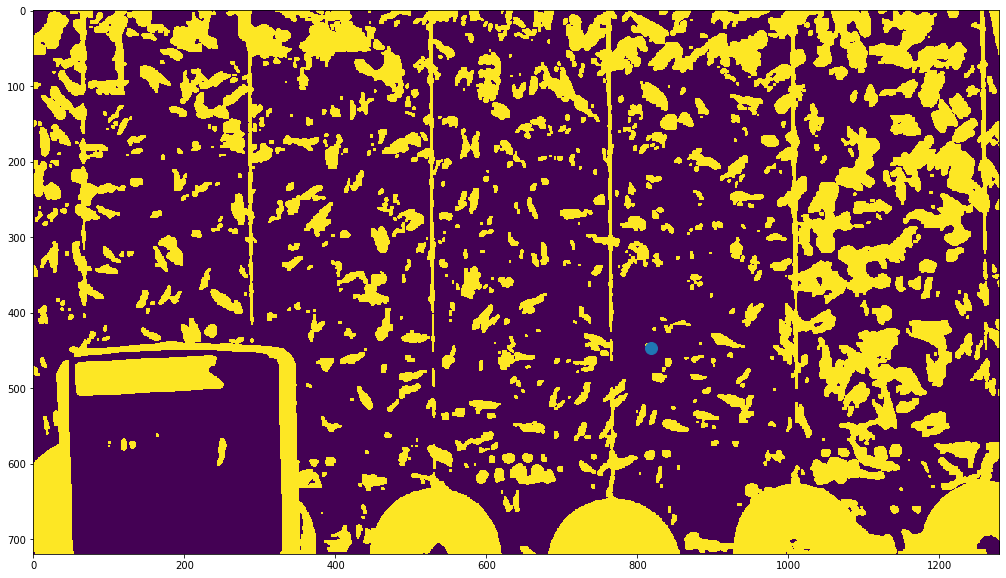

In [23]:
cap.set(1, 251)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
opening = cv2.dilate(thresh, kernel, iterations=2)



plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(818, 447, marker='o', markersize=12)

In [21]:
clust[clust['frame']==223]
clust

,index,x,y,frame,size,contour,Cluster
122,122,839,481,201,259.0,"[[[853, 458]], [[852, 459]], [[853, 458]], [[8...",6
123,123,828,485,223,344.5,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",6
124,124,834,488,224,508.0,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",6
125,125,825,482,225,336.5,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",6
126,126,825,484,226,484.0,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",6
127,127,823,483,227,342.5,"[[[818, 467]], [[818, 468]], [[817, 469]], [[8...",6
128,128,823,478,235,303.5,"[[[824, 466]], [[823, 467]], [[822, 468]], [[8...",6
129,129,823,479,237,244.5,"[[[822, 461]], [[821, 462]], [[820, 463]], [[8...",6
130,130,826,471,238,405.0,"[[[827, 458]], [[826, 459]], [[825, 460]], [[8...",6
131,131,819,474,239,413.0,"[[[823, 458]], [[822, 459]], [[821, 460]], [[8...",6


In [ ]:
missing = list(set(rang)-set(clust.frame.values))
missing